In [20]:
import pandas as pd
import numpy as np

from modeling.linear_models import LinearRegressions
from modeling.plots import plot_data, plot_daily_data

In [ ]:
SolarData22 = pd.read_csv('../data/Processed/Solar2022.csv',index_col=0,parse_dates=[0])
SolarData23 = pd.read_csv('../data/Processed/Solar2023.csv',index_col=0,parse_dates=[0])
SolarData24 = pd.read_csv('../data/Processed/Solar2024.csv',index_col=0,parse_dates=[0])

#Restrict to when sun ~above horizon
SolarDataDay22 = SolarData22[SolarData22['Solar Zenith Angle']<np.pi/2].dropna()
SolarDataDay23 = SolarData23[SolarData23['Solar Zenith Angle']<np.pi/2].dropna()
SolarDataDay24 = SolarData24[SolarData24['Solar Zenith Angle']<np.pi/2].dropna()

In [23]:
LinearModels = LinearRegressions(SolarDataDay22,SolarDataDay23)

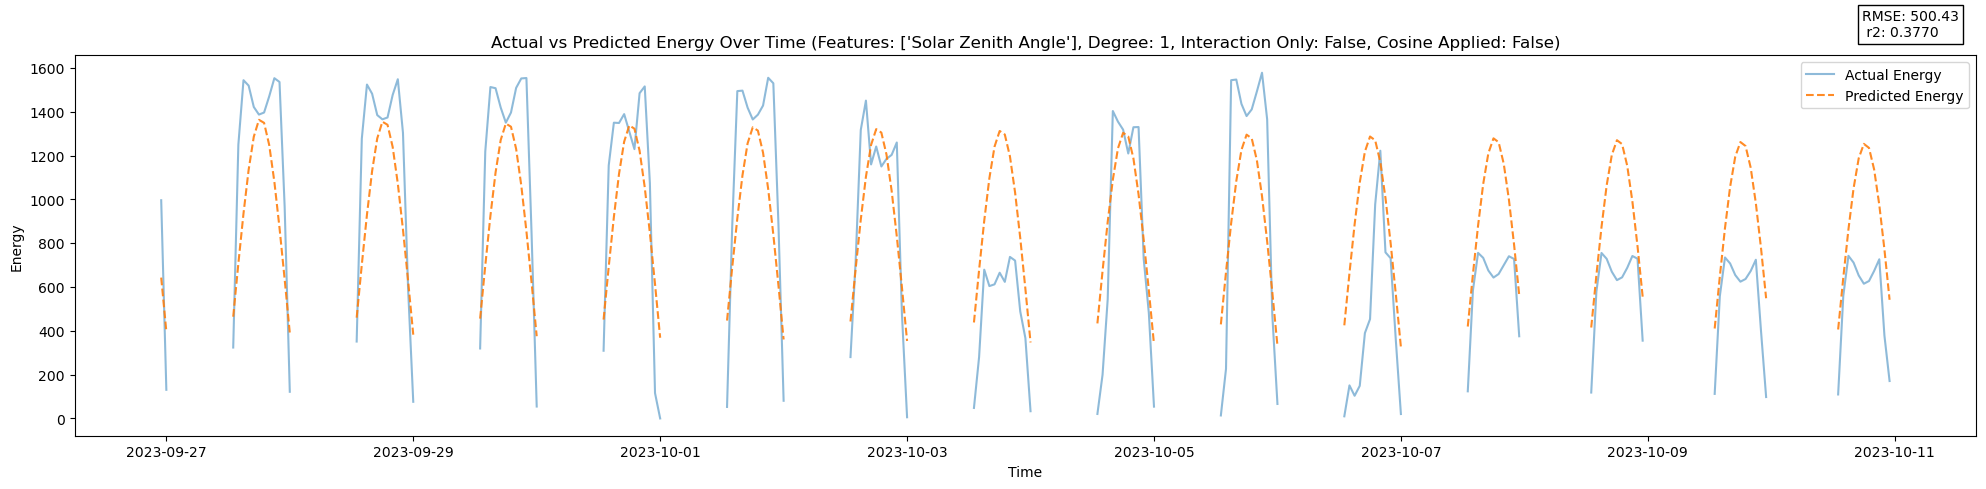

In [24]:
key = (['Solar Zenith Angle'],1,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

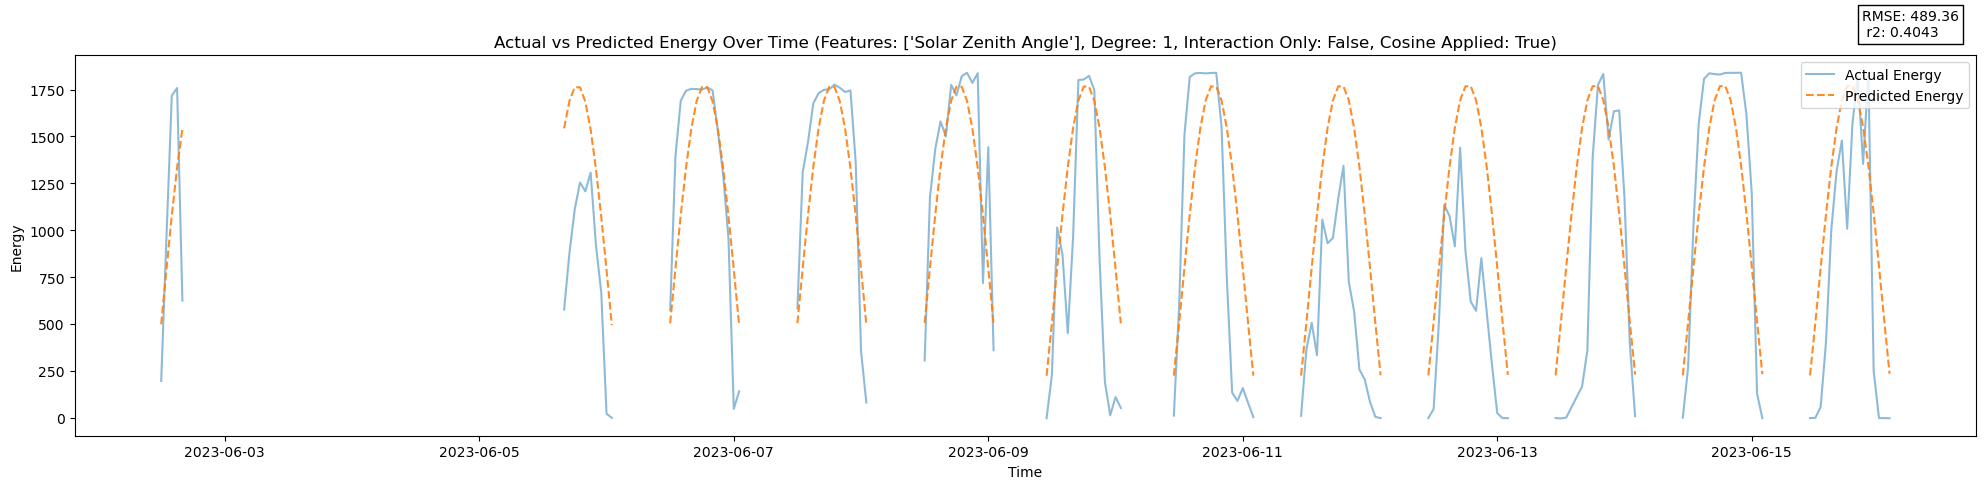

In [25]:
key = (['Solar Zenith Angle'],1,False,True)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

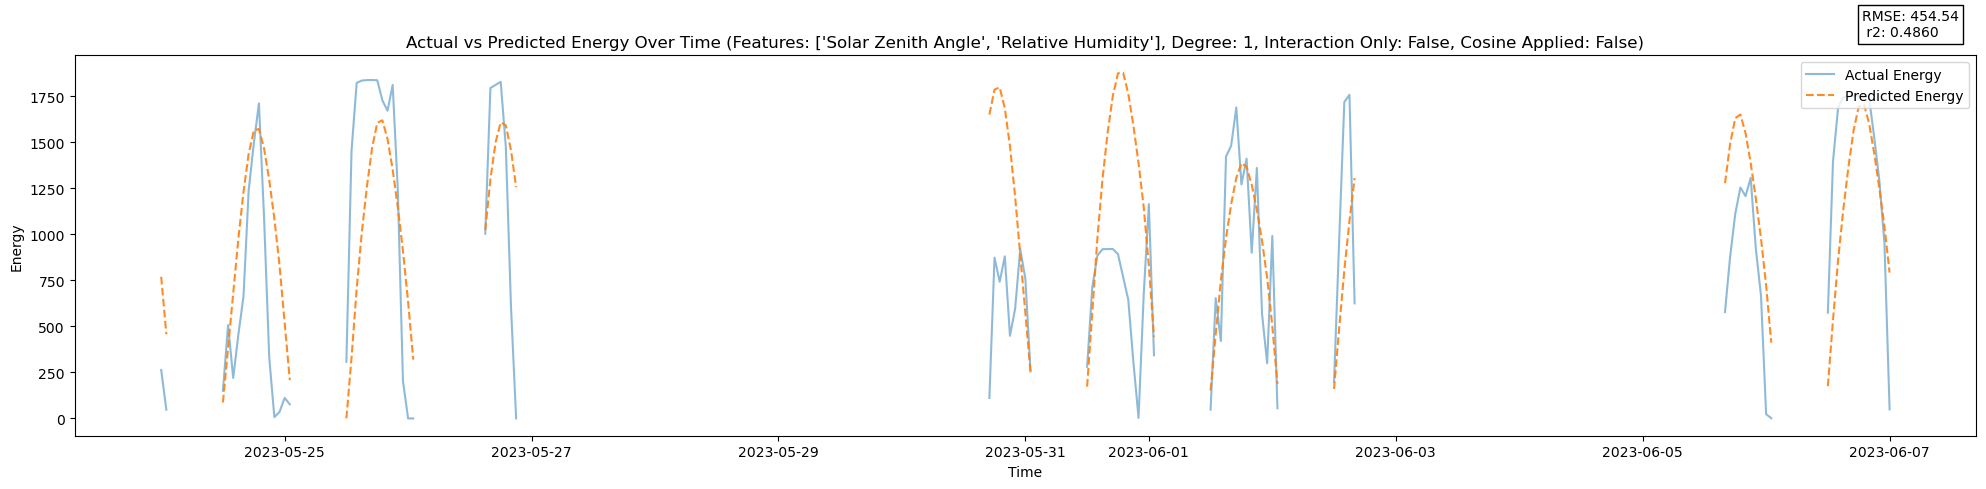

In [26]:
key = (['Solar Zenith Angle','Relative Humidity'],1,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

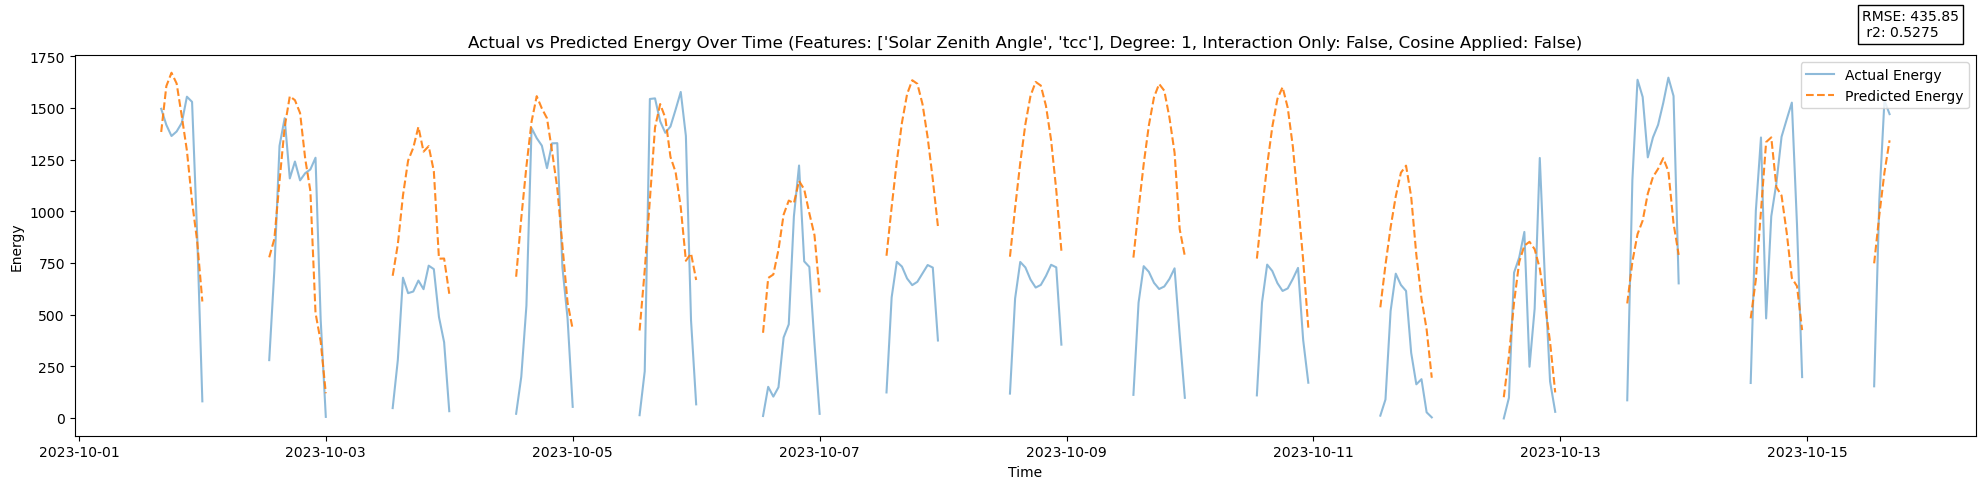

In [27]:
key = (['Solar Zenith Angle','tcc'],1,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

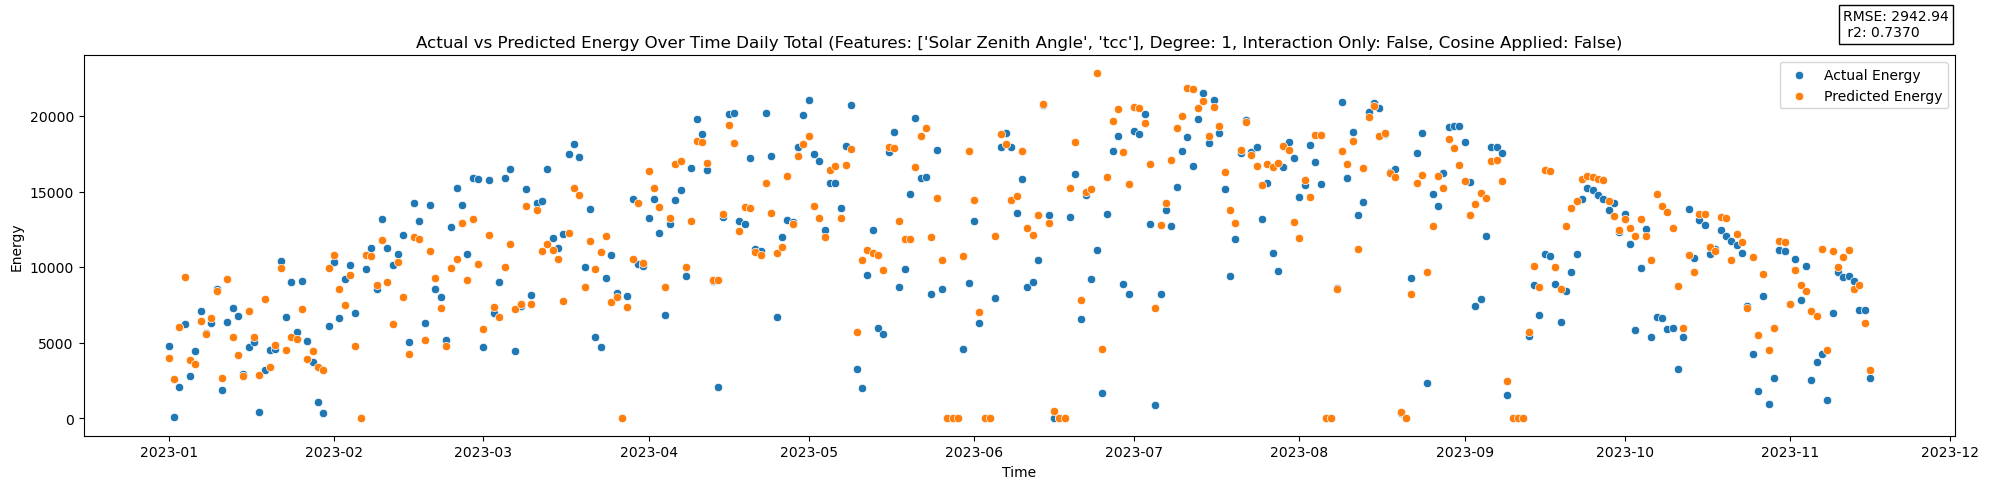

In [28]:
plot_daily_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

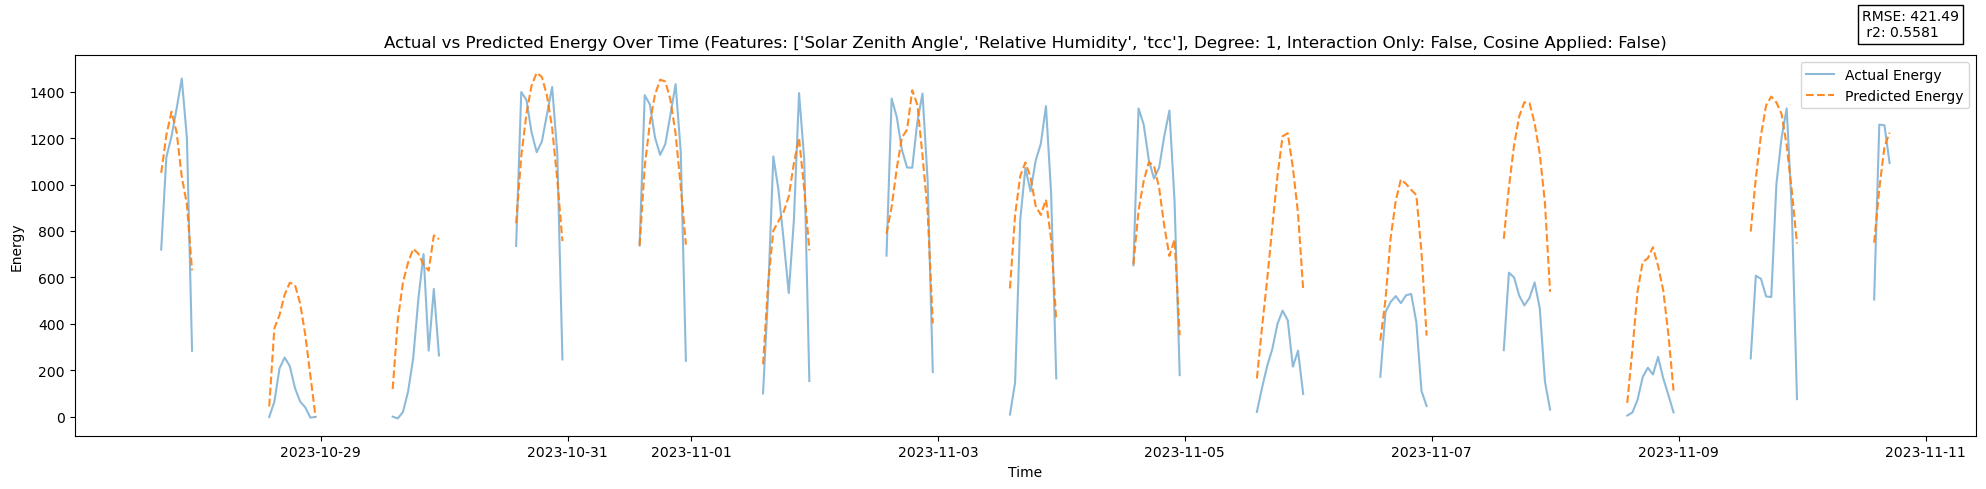

In [29]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],1,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

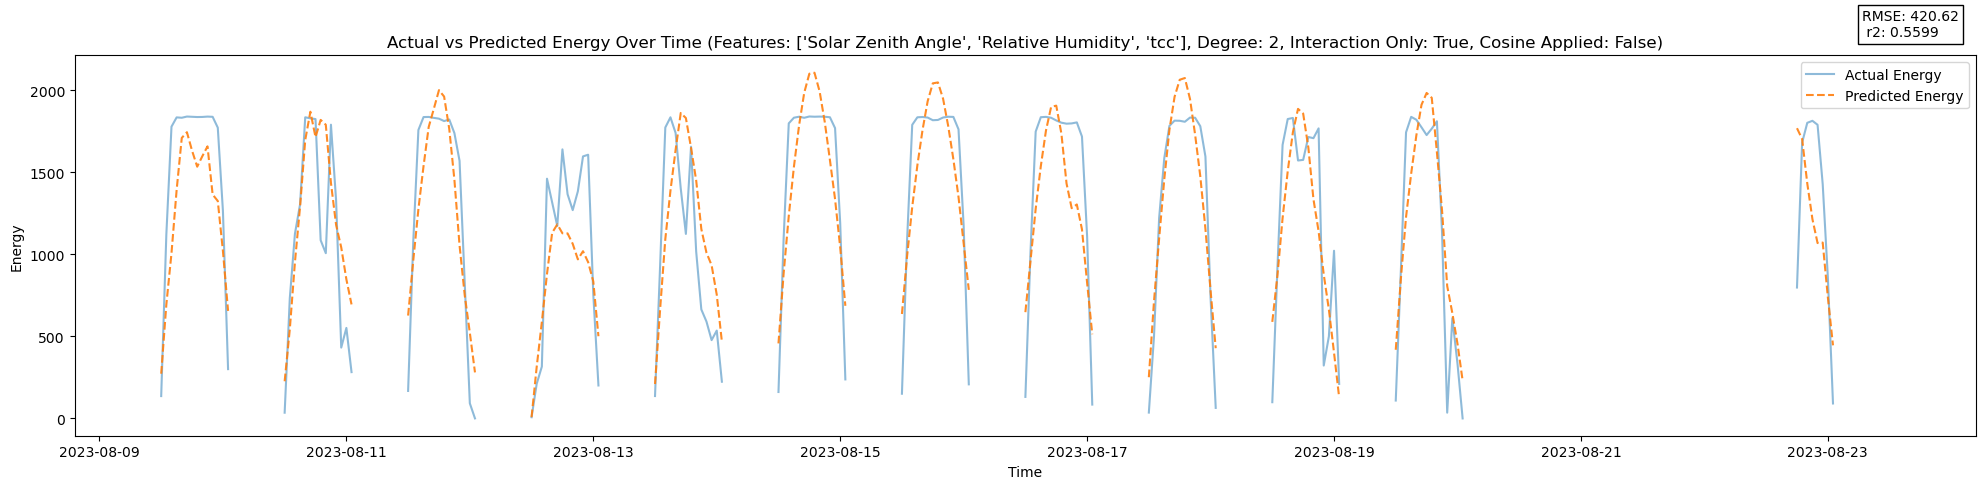

In [30]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],2,True,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

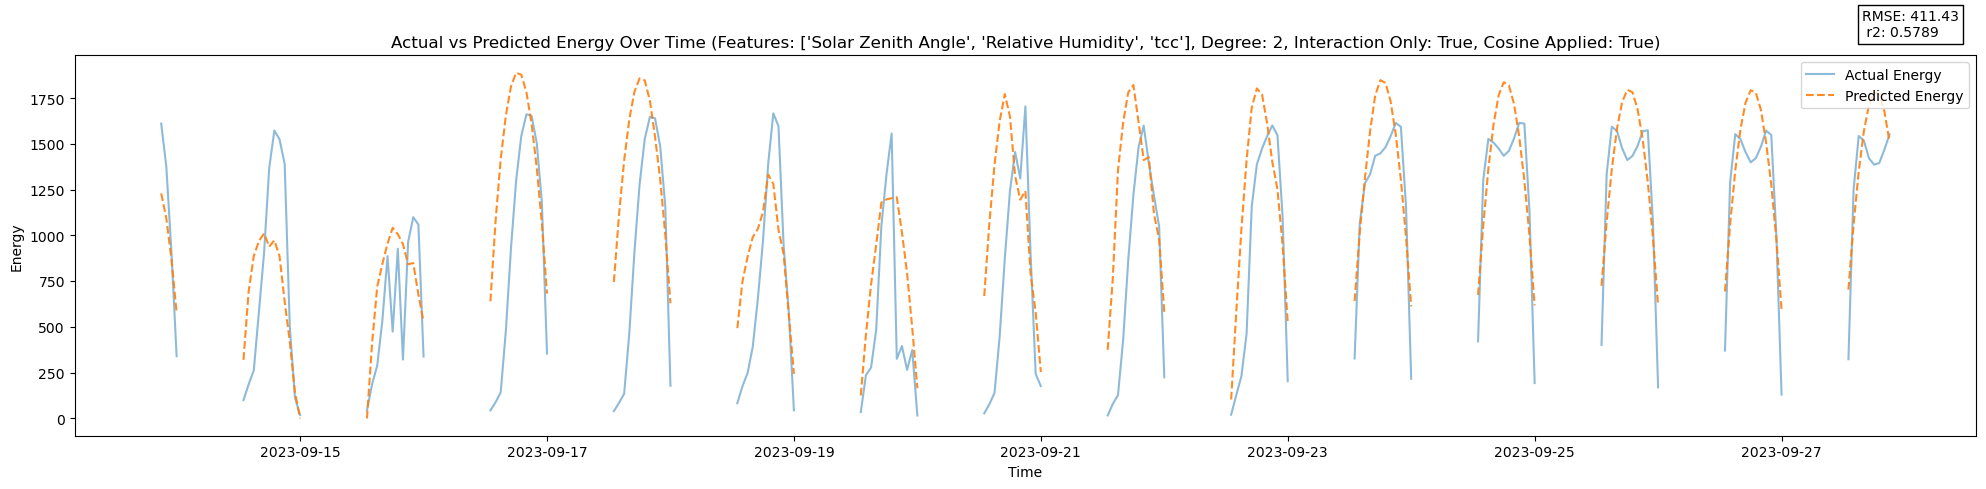

In [43]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],2,True,True)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

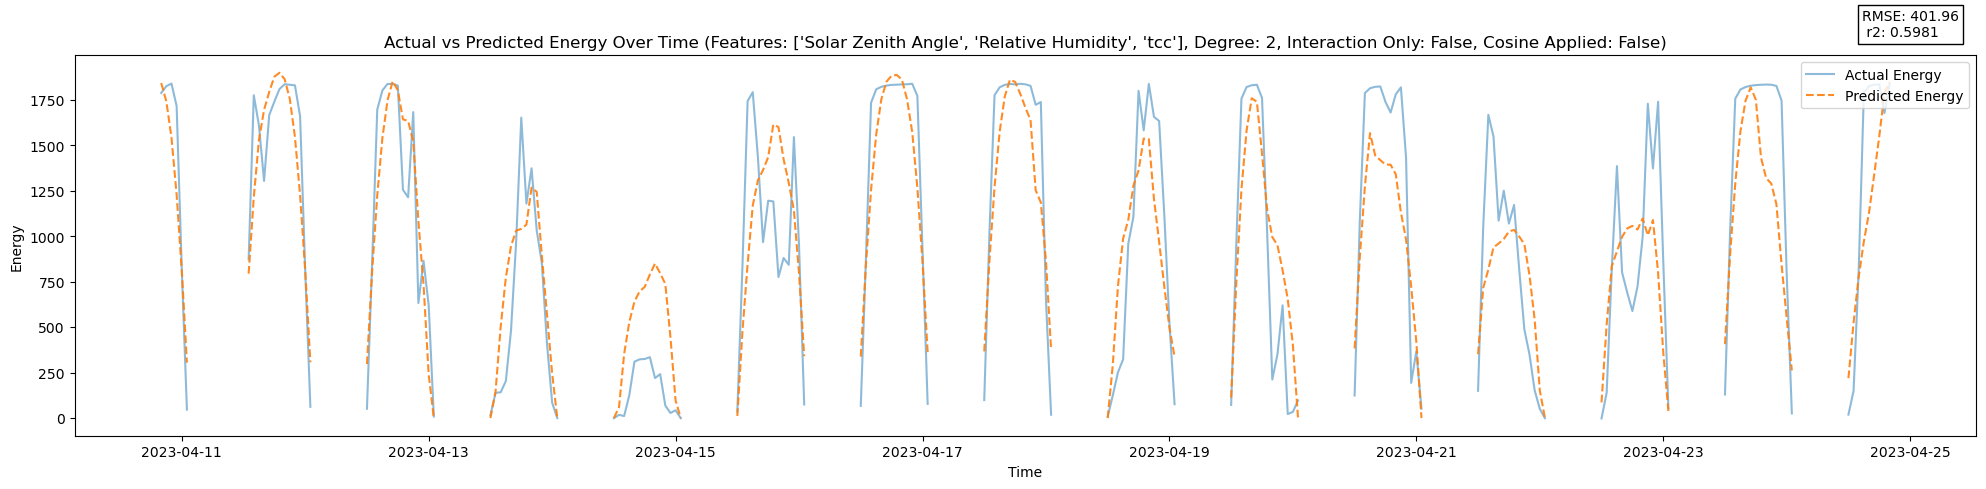

In [32]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],2,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

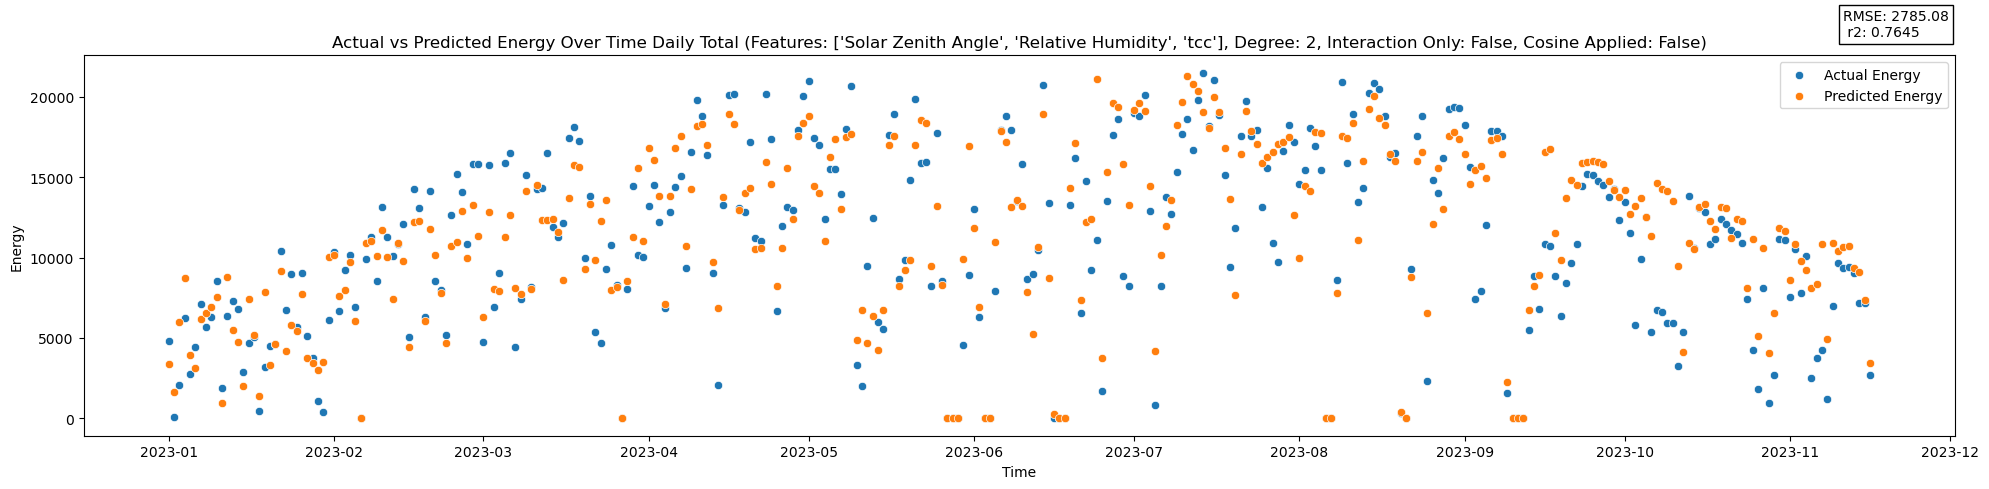

In [33]:
plot_daily_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

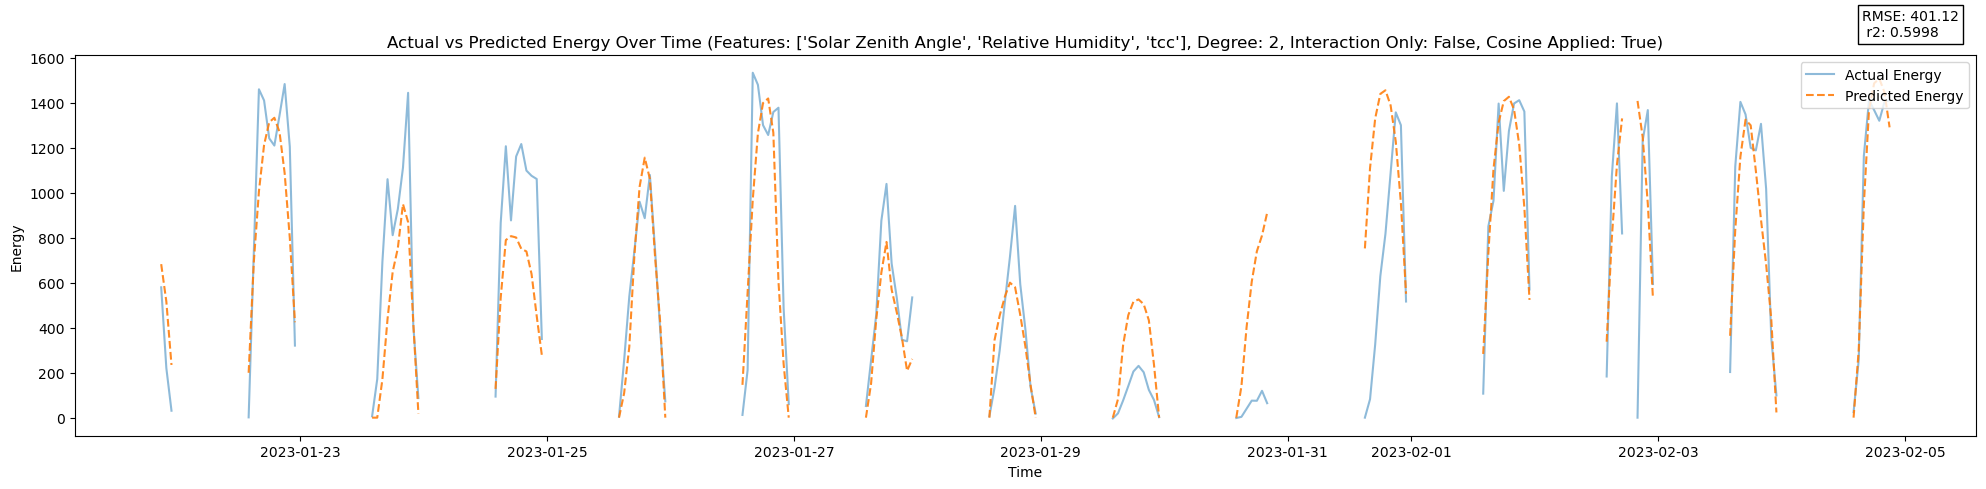

In [34]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],2,False,True)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

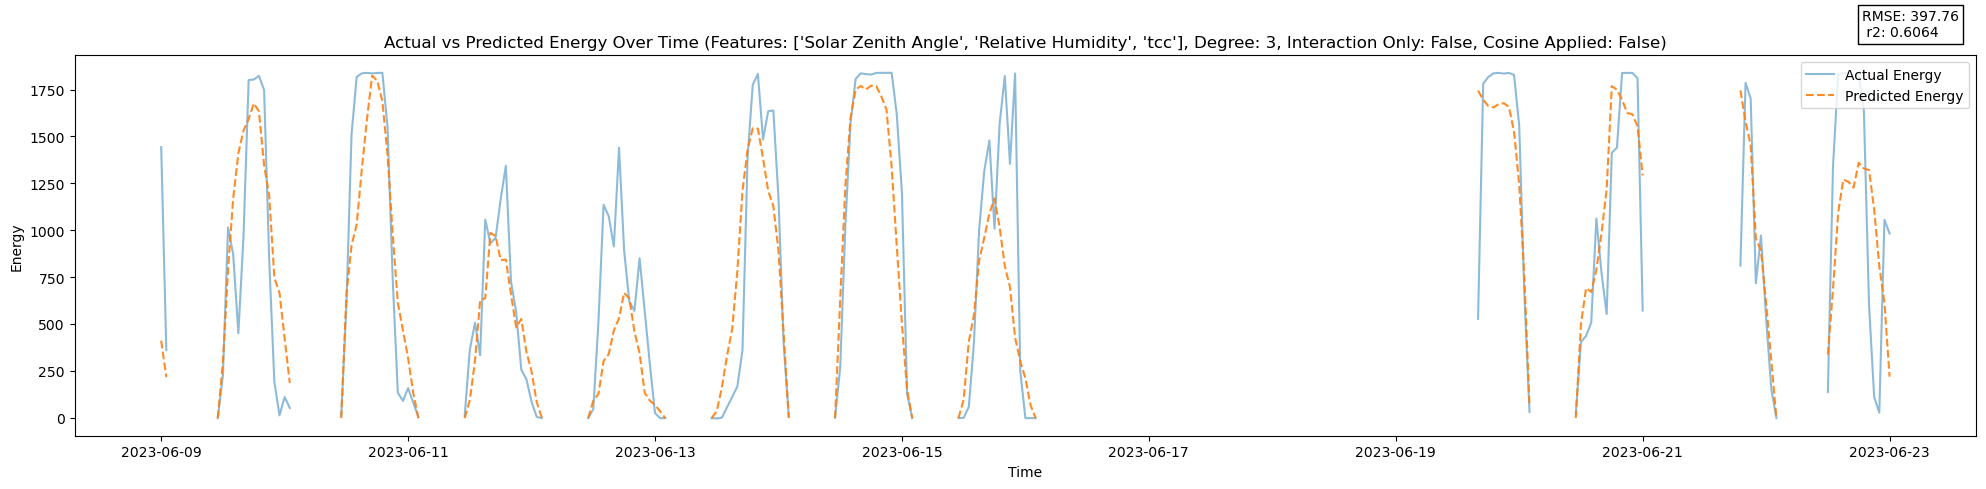

In [35]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],3,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

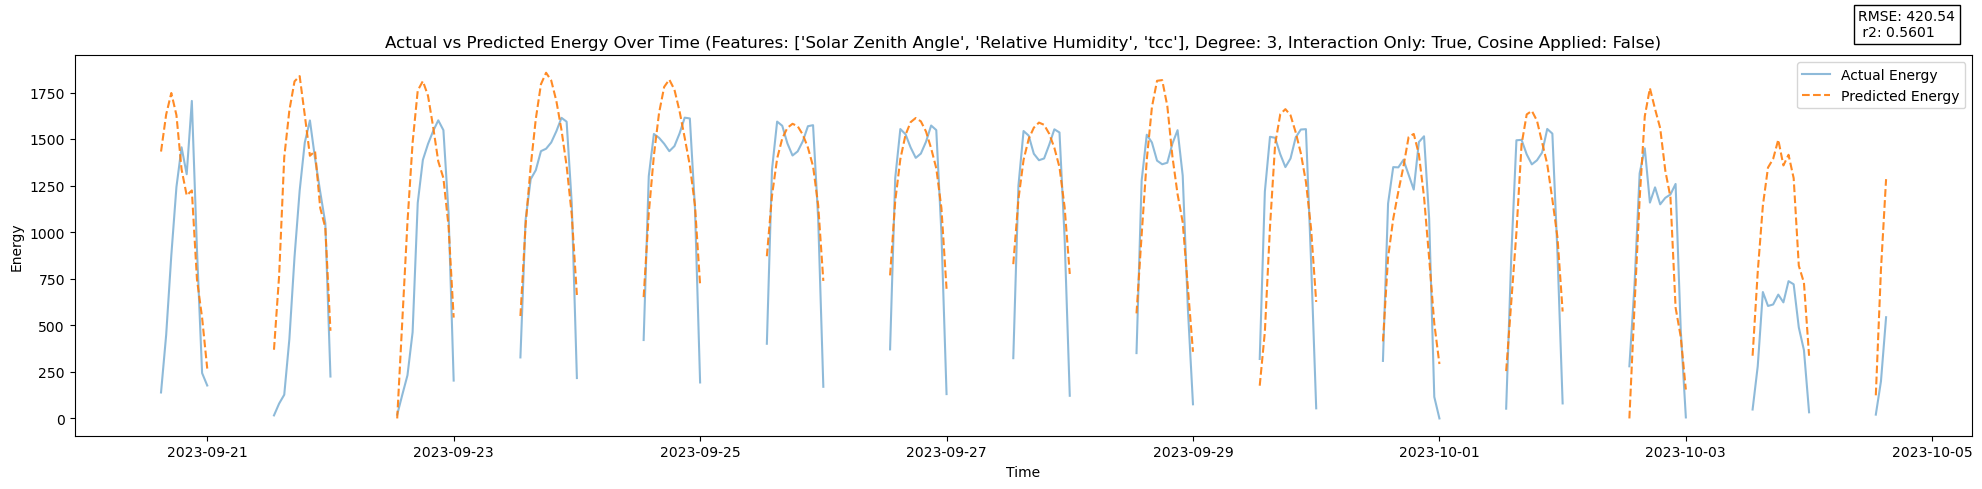

In [36]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],3,True,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

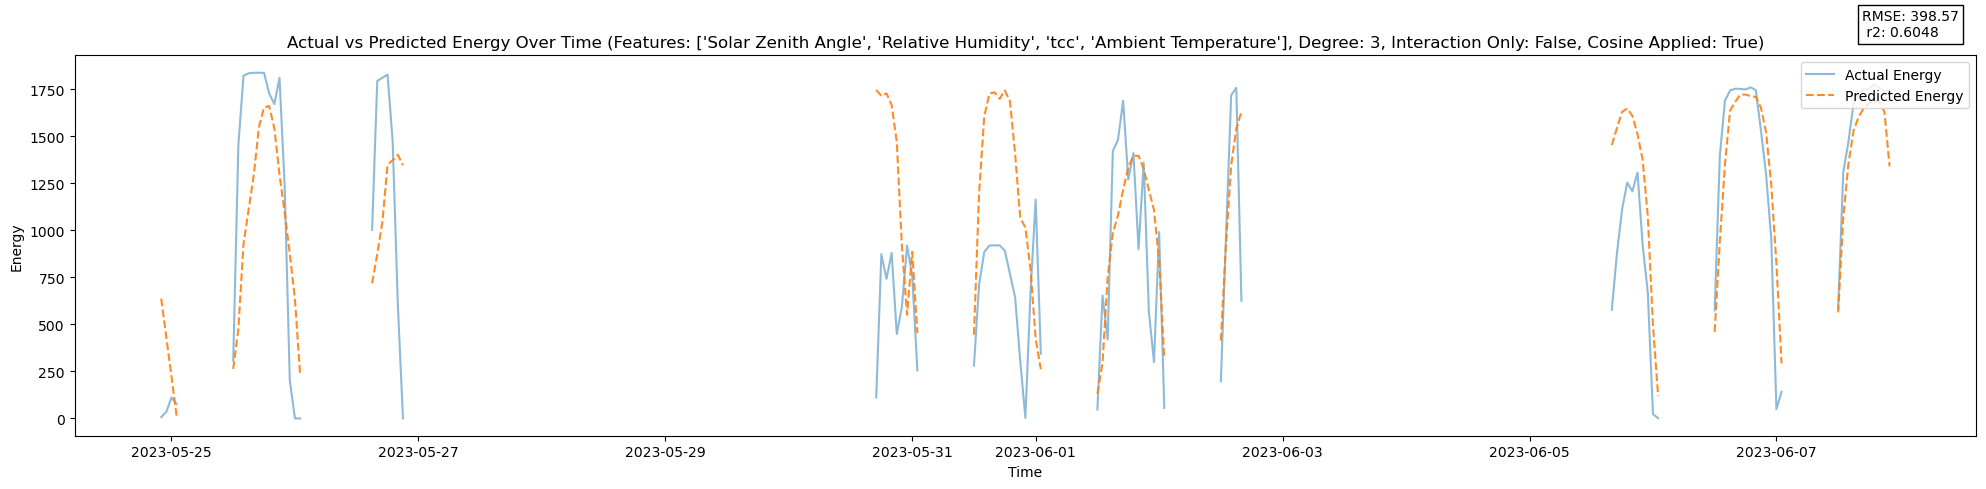

In [37]:
key = (['Solar Zenith Angle','Relative Humidity','tcc','Ambient Temperature'],3,False,True)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

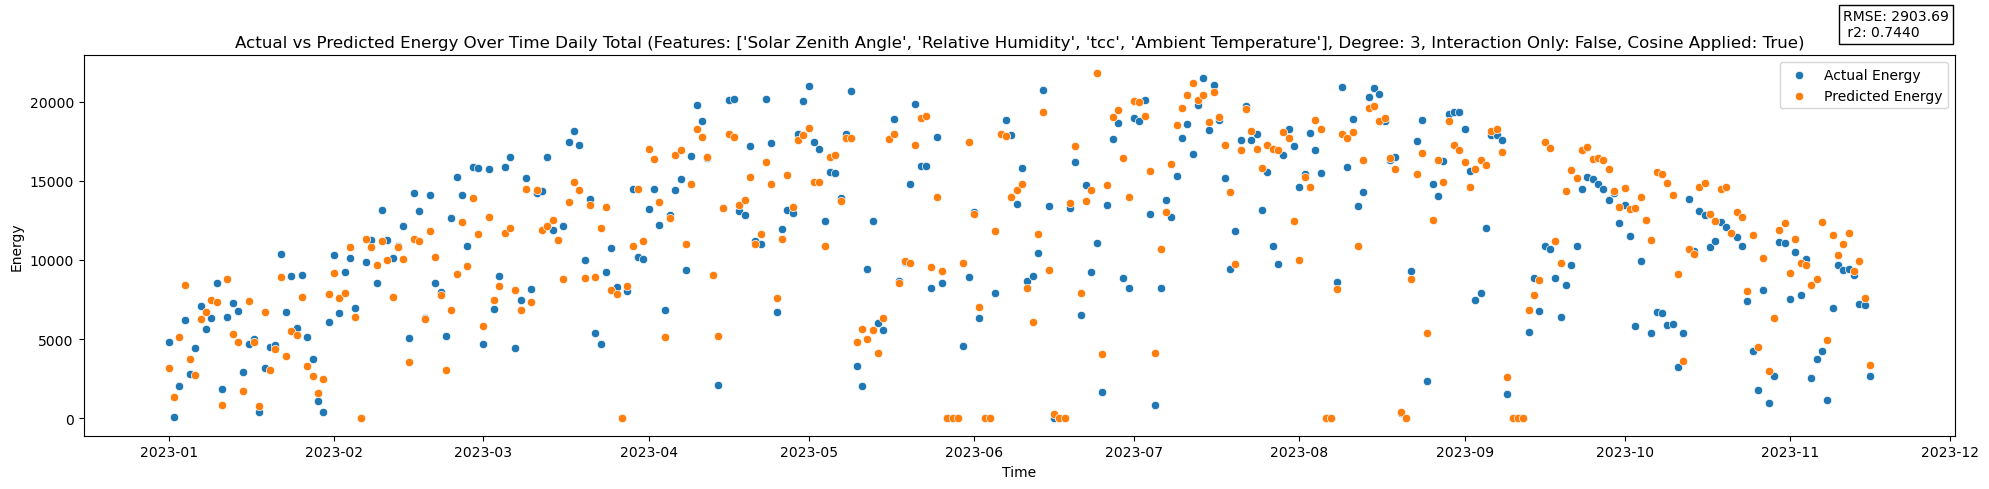

In [38]:
plot_daily_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

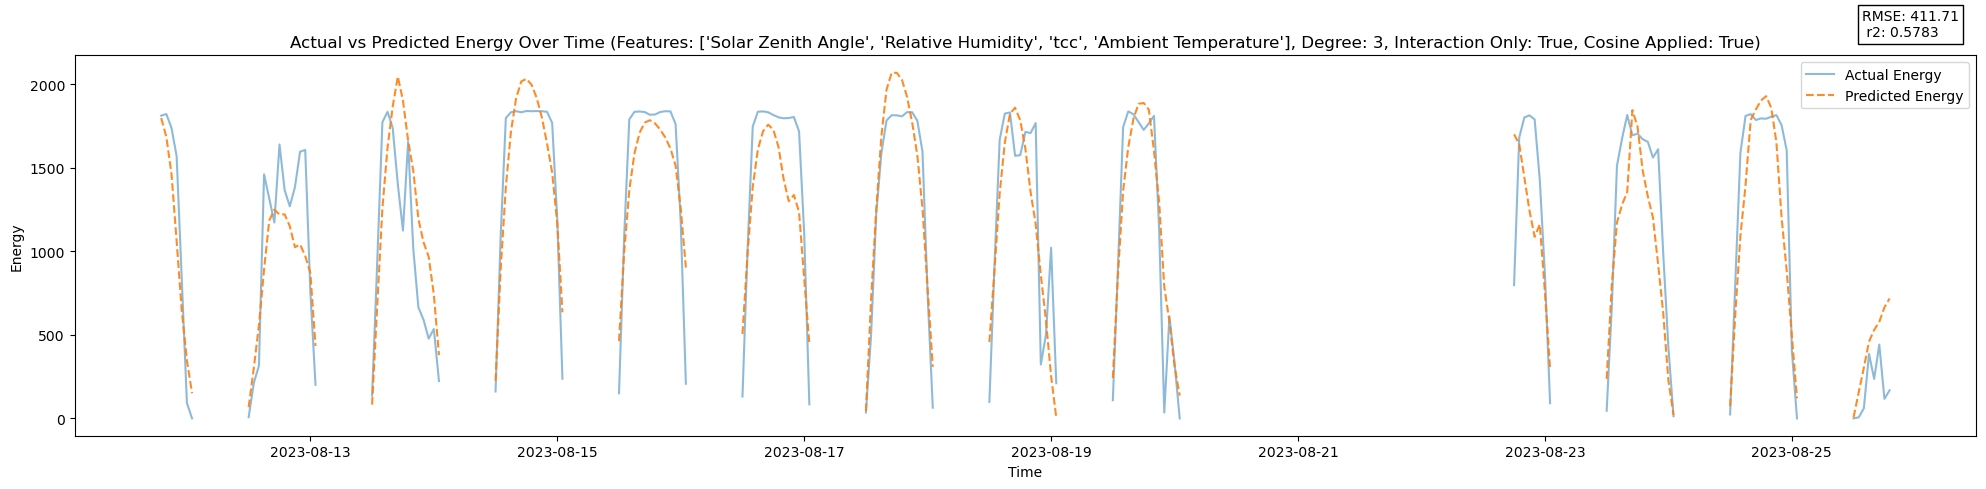

In [39]:
key = (['Solar Zenith Angle','Relative Humidity','tcc','Ambient Temperature'],3,True,True)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

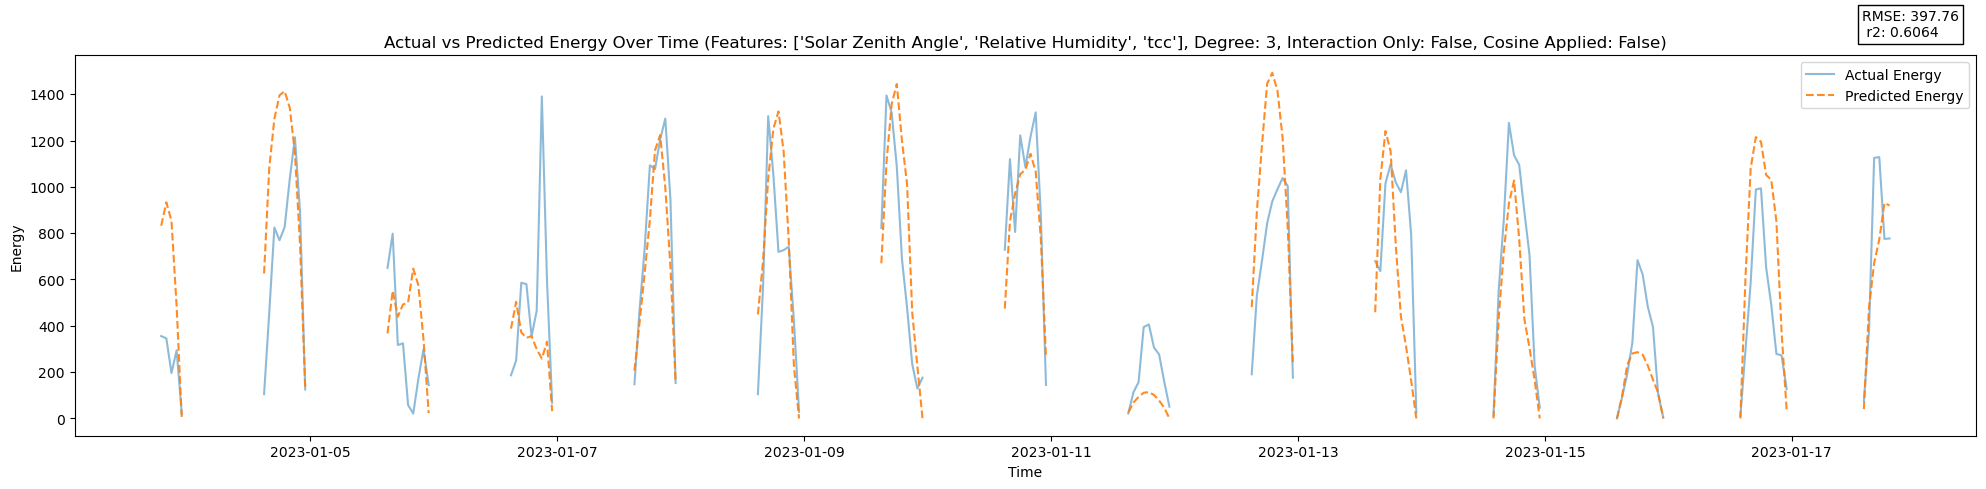

In [40]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],3,False,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

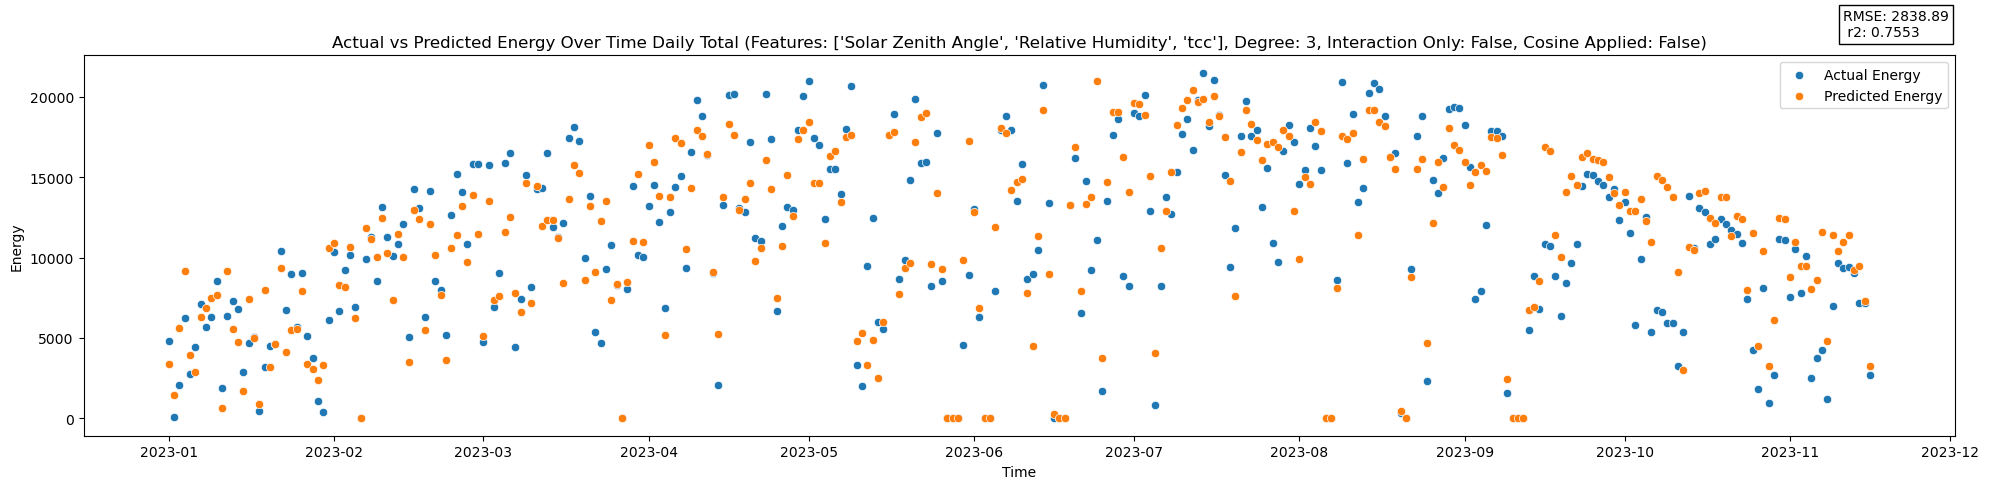

In [41]:
plot_daily_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

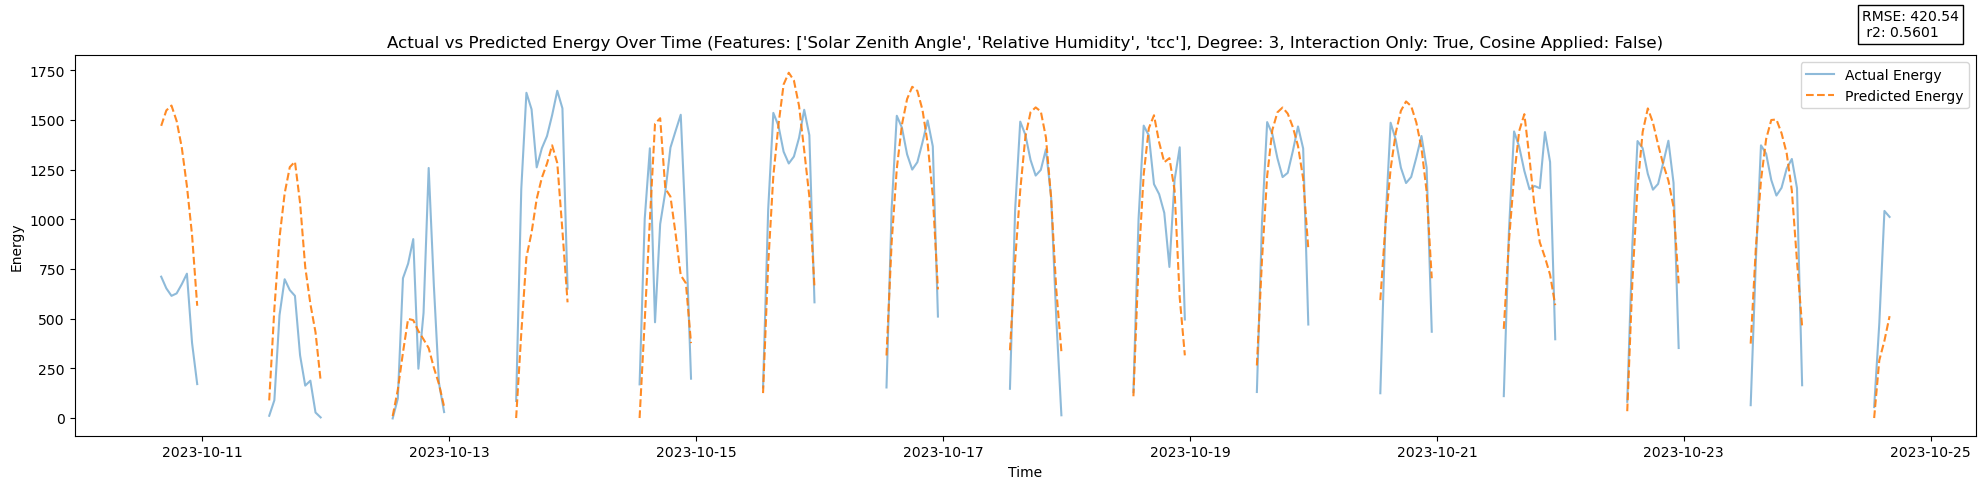

In [42]:
key = (['Solar Zenith Angle','Relative Humidity','tcc'],3,True,False)
LinearModels.fit(*key)
plot_data('Features: {}, Degree: {}, Interaction Only: {}, Cosine Applied: {}'.format(*key),LinearModels.predictions(*key))

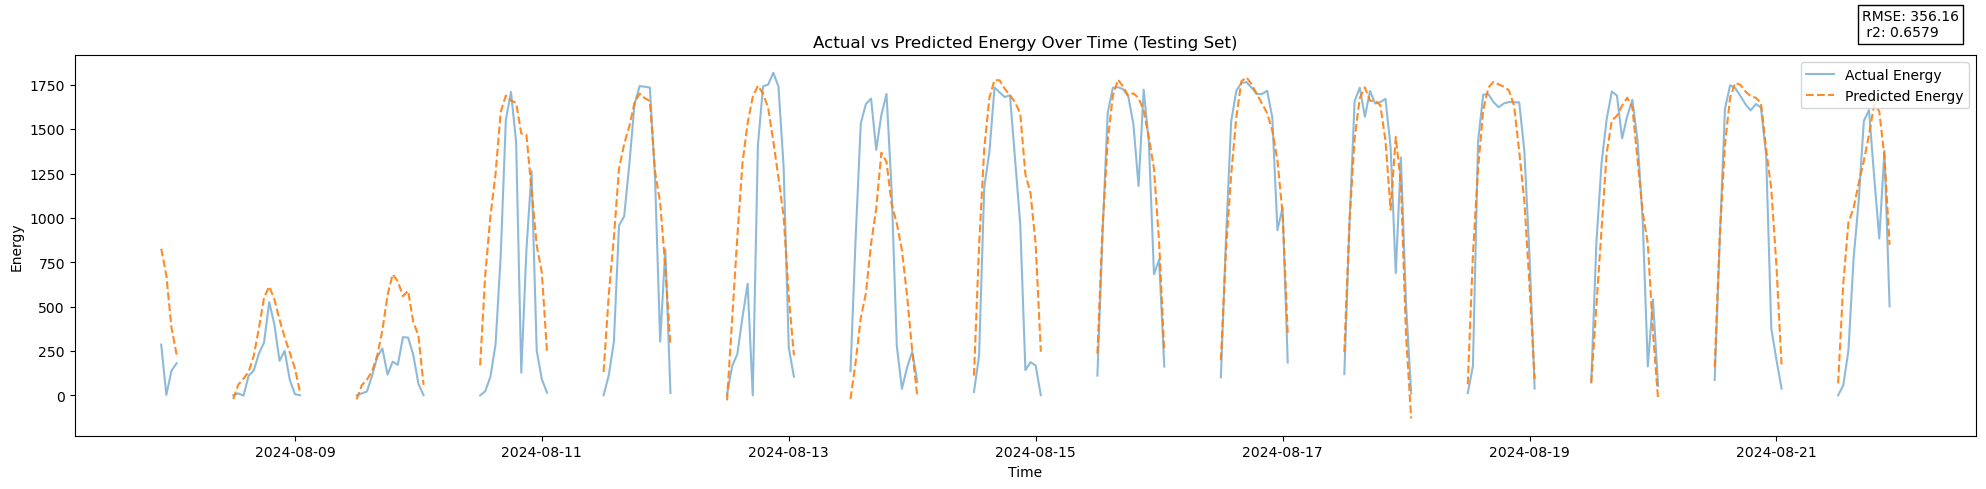

In [44]:
features = ['Solar Zenith Angle','Relative Humidity','tcc']
key = (['Solar Zenith Angle','Relative Humidity','tcc'],3,False,False)
best_model = LinearModels.get_model(*key)

TestSetOutput = SolarDataDay24[['Energy']].copy()
TestSetOutput['Prediction'] = best_model.predict(SolarDataDay24[features])
plot_data('Testing Set', TestSetOutput)